## EDA on historical daily price returns

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white")
plt.style.use('default') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

In [2]:
sp500_profile_df = pd.read_csv('../data/stocks_profile.csv')
print(f'Total count of stocks in profile data: {len(sp500_profile_df.ticker.unique())}')
# sp500_profile_df.head()
stocks_hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
stocks_hist_price_df.date = pd.to_datetime(stocks_hist_price_df.date, format='ISO8601')
print(f'Total count of stocks in hist price data: {len(stocks_hist_price_df.ticker.unique())}')
# stocks_hist_price_df.head()
stocks_hist_ratios_df = pd.read_csv('../data/stocks_hist_ratios.csv')
print(f'Total count of stocks in hist ratios data: {len(stocks_hist_ratios_df.ticker.unique())}') 
# stocks_hist_ratios_df.head()

Total count of stocks in profile data: 503
Total count of stocks in hist price data: 502
Total count of stocks in hist ratios data: 502


### 1. Data cleanup and insights - Hist Price data

In [3]:
stocks_hist_price_df.shape

(1588930, 12)

In [4]:
# Check for any null values
stocks_hist_price_df.isna().sum()

ticker                 0
date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
Dividend amount        0
Split coefficient      0
simple_return        502
log_return           502
dtype: int64

In [5]:
# The missing values (null) seem to be the first date null values for each stock's 
# simple & log returns (left out while computing returns). Let's get rid of them.
stocks_hist_price_df.dropna(inplace=True)
stocks_hist_price_df.reset_index(drop=True, inplace=True)
stocks_hist_price_df.isna().sum()

ticker               0
date                 0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Dividend amount      0
Split coefficient    0
simple_return        0
log_return           0
dtype: int64

---

In [6]:
# Define the training & test periods
training_start_date = dt.datetime(2010, 1, 5)
training_last_date = dt.datetime(2019, 12, 31)
test_start_date = dt.datetime(2020, 1, 1)
test_last_date = dt.datetime(2021, 12, 31)

In [7]:
# Check for stocks with initial date of data availability not later than 2010-01-05
first_dates = stocks_hist_price_df.groupby(['ticker']).first()
f_date_NA_stocks = list(first_dates[first_dates.date > training_start_date].index)
print(f'Historical price data is not available for {len(f_date_NA_stocks)} stocks from the set initial date of {training_start_date.date()}\n')
print(f'List of stocks for which data is not avilable from the desired date: \n{f_date_NA_stocks}\n')

# Check for stocks with last date of data availability no earlier than 2019-12-31
last_dates = stocks_hist_price_df.groupby(['ticker']).last()
l_date_NA_stocks = list(last_dates[last_dates.date < training_last_date].index)
print(f'Complete historical price data is not available for {len(l_date_NA_stocks)} stocks till last date of {training_last_date.date()}\n')
print(f'List of stocks for which data is not avilable till the desired date: \n{l_date_NA_stocks}\n')

refined_stock_list = [tick for tick in stocks_hist_price_df.ticker.unique() if tick not in f_date_NA_stocks or l_date_NA_stocks]
print(f'Total number of stocks left in the universe after the date filter: {len(refined_stock_list)}')

Historical price data is not available for 69 stocks from the set initial date of 2010-01-05

List of stocks for which data is not avilable from the desired date: 
['ABBV', 'ALLE', 'AMCR', 'ANET', 'APTV', 'BKR', 'CARR', 'CBOE', 'CDAY', 'CDW', 'CEG', 'CFG', 'CHTR', 'CTLT', 'CTVA', 'CZR', 'DOW', 'DXC', 'ENPH', 'EPAM', 'ETSY', 'EVRG', 'FANG', 'FLT', 'FOX', 'FOXA', 'FRC', 'FTV', 'GEHC', 'GM', 'GNRC', 'GOOG', 'HCA', 'HII', 'HLT', 'HPE', 'INVH', 'IQV', 'KEYS', 'KHC', 'KMI', 'LIN', 'LW', 'LYB', 'META', 'MPC', 'MRNA', 'MTCH', 'NCLH', 'NOW', 'NWS', 'NWSA', 'NXPI', 'OGN', 'OTIS', 'PAYC', 'PSX', 'PYPL', 'QRVO', 'SEDG', 'SYF', 'TRGP', 'TSLA', 'VICI', 'VTRS', 'WRK', 'WTW', 'XYL', 'ZTS']

Complete historical price data is not available for 0 stocks till last date of 2019-12-31

List of stocks for which data is not avilable till the desired date: 
[]

Total number of stocks left in the universe after the date filter: 433


In [8]:
# Define the training data (historical price information) for the filtered stock universe
h_prices_train = stocks_hist_price_df[(stocks_hist_price_df.ticker.isin(refined_stock_list)) & (stocks_hist_price_df.date<=training_last_date)]
h_prices_train.reset_index(drop=True, inplace=True)

In [9]:
# fetch the historical log returns
hist_log_ret = h_prices_train.pivot_table(values='log_return', index='date', columns='ticker')
hist_log_ret.tail()

ticker,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WST,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,0.000469,-0.004104,0.003744,0.000950,-0.002105,-0.000802,-0.001308,0.003693,0.002095,0.004605,...,-0.003179,-0.009668,-0.005650,0.003880,-0.003849,0.000525,0.005196,-0.002449,-0.009392,0.003694
2019-12-26,0.001757,0.016653,-0.008129,0.019646,-0.004341,0.000000,0.004038,0.002077,0.004721,0.000084,...,0.000265,0.004679,0.010700,-0.001114,0.001570,-0.010190,0.014447,-0.002190,0.000354,0.002520
2019-12-27,-0.000351,-0.042340,-0.005793,-0.000380,-0.001647,0.001374,0.008969,0.000801,-0.001239,-0.002341,...,0.000265,-0.000334,-0.008050,0.005242,-0.003428,0.005469,0.001080,-0.001931,0.006191,-0.003102
2019-12-30,-0.003988,-0.004935,0.004851,0.005918,-0.015070,-0.006889,0.003986,-0.007473,-0.007434,-0.004952,...,0.000000,-0.001669,-0.003080,0.002690,-0.005884,-0.007771,-0.012442,-0.008435,-0.007410,0.005229
2019-12-31,0.004818,0.013338,0.006515,0.007280,0.016365,0.000691,0.003737,-0.000332,0.004467,-0.000168,...,-0.003188,0.008981,-0.003666,0.003155,0.004308,0.003363,0.000894,0.006233,0.005220,0.002893


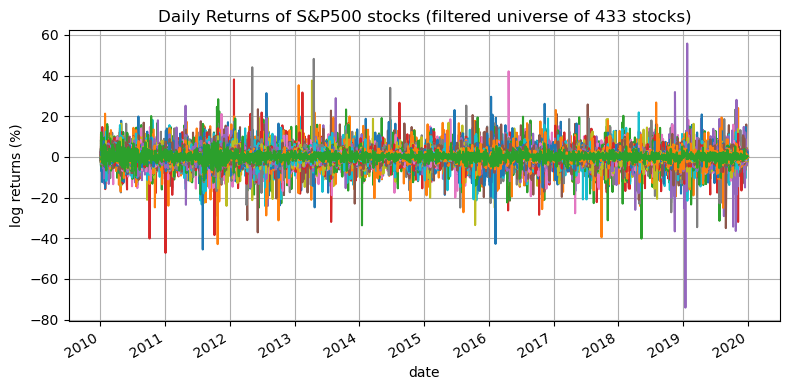

In [10]:
# Plot the daily log returns of all stocks in the defined universe
(hist_log_ret * 100).plot(figsize=(8,4), grid=True, 
                  title=f'Daily Returns of S&P500 stocks (filtered universe of {len(hist_log_ret.columns)} stocks)', 
                  ylabel='log returns (%)', fontsize=10.0, legend=0)
plt.tight_layout()
# plt.savefig('tmp.png')

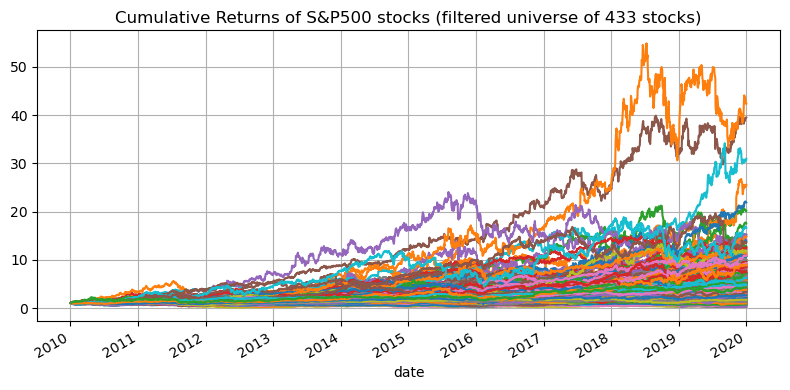

In [11]:
# Cummulative log returns of all stocks in the stock universe
(hist_log_ret.cumsum().apply(np.exp)).plot(figsize=(8,4), grid=True, 
                                           title=f'Cumulative Returns of S&P500 stocks (filtered universe of {len(hist_log_ret.columns)} stocks)',
                                           fontsize=10.0, legend=0)
plt.tight_layout()
# plt.savefig('tmp.png')

### 2. Clustering stocks based just on historical log returns

#### 2.1 Use PCA to reduce the dimensionality of the data before proceeding with clustering process

In [12]:
# Standardise & normalise data
def std_normalise_data(data = pd.DataFrame()):
    """
    Standardise & normalise input data
    """
    new_data = StandardScaler().fit_transform(data)
    new_data = Normalizer().fit_transform(new_data) 
    new_df = pd.DataFrame(new_data, index=data.index)

    return new_df

log_ret_norm_df = std_normalise_data(hist_log_ret.T)
log_ret_norm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514
ticker,,,,,,,,,,,,,,,,,,,,,
A,-0.016914,-0.007552,-0.007954,-0.004050,-0.003333,-0.001387,-0.004395,0.019774,-0.021130,-0.001160,...,-0.012509,-0.012738,0.015884,0.003262,0.001912,0.000382,-0.001305,0.000953,-0.000858,0.005307
AAL,0.060662,-0.028550,0.012720,-0.015827,-0.017598,0.010297,0.055317,0.013377,-0.004273,0.010423,...,0.011324,-0.009836,0.013571,0.010235,0.008062,-0.009630,0.026103,-0.070724,-0.002083,0.019766
AAP,-0.008178,0.006090,-0.005017,0.001646,-0.014797,-0.005504,0.004269,-0.015377,0.006418,-0.009975,...,0.039087,-0.000256,-0.016998,0.005848,0.015569,0.010756,-0.027409,-0.013041,0.022423,0.009004
AAPL,-0.001774,-0.020866,-0.007558,0.005445,-0.016230,-0.000600,0.005389,-0.008834,-0.008561,0.045749,...,0.002103,-0.004841,-0.004208,-0.014298,0.025713,0.002175,0.055992,0.000755,0.030099,0.013489
ABC,-0.012202,-0.014876,-0.023872,0.012042,0.012878,0.019108,0.014995,0.007210,0.001010,0.006327,...,-0.062521,0.007977,-0.001279,0.029703,-0.000970,-0.010519,-0.022857,-0.003401,-0.039085,0.050948


Method 1 - variance explained by components


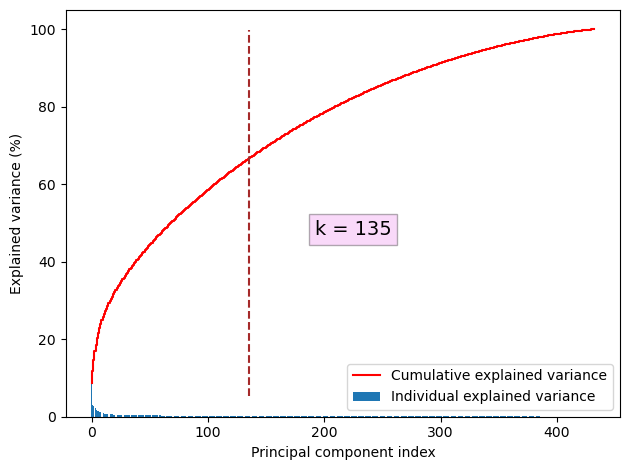

Knee point, explained variance (%) : (135, 66.60317804553041)

---------------------------------------------------------------------

Method 2 - Scree plot


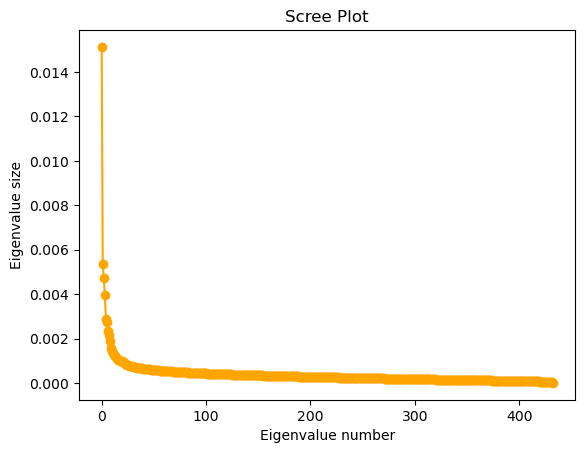

In [13]:
def pca_tuning(data = pd.DataFrame()):
    """
    PCA tuning 
    method 1 - Plot the cummulative explained variance against the count of principal components
    method 2 - Create a Scree plot which gives the visual representation of eigenvalues 
    that define the magnitude of eigenvectors (principal components)
    """
    # Start with basic PCA, keeping all components with no reduction   
    pca_base = PCA(n_components=None)
    pca_base.fit(data)

    # Method 1
    # Fetch variance explained by each individual component & compute the cummulative sum
    print('Method 1 - variance explained by components') 
    exp_var = pca_base.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)
    knee = KneeLocator(range(0, cum_exp_var.size), cum_exp_var, S=20, curve='concave', direction='increasing', interp_method='interp1d')
    plt.bar(range(0, exp_var.size), exp_var, align='center', label='Individual explained variance')
    plt.step(range(0, cum_exp_var.size), cum_exp_var, where='mid', label='Cumulative explained variance', color='red')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.figtext(0.5, 0.5, f'k = {knee.knee}', bbox=dict(facecolor='violet', alpha=0.3), fontsize=14)
    plt.tight_layout()
    plt.show()
    print(f'Knee point, explained variance (%) : {knee.knee, cum_exp_var[knee.knee]}')

    # Method 2 - Scree plot
    print('\n---------------------------------------------------------------------\n')
    print('Method 2 - Scree plot')
    plt.plot(pca_base.explained_variance_, marker='o', color='orange')
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue size")
    plt.title("Scree Plot")
    plt.show()

    return pca_base, knee.knee

# Note: PCA needs the input data to be in (n_features, n_samples) format
# for it to function properly and reduce the feature dimensionality
pca_base, knee_point_comps = pca_tuning(log_ret_norm_df.T)

##### Method 1:
 The number of bars is equal to the number of variables in the original dataset. In this plot, each bar shows the explained variance percentage of individual components and the step plot shows the cumulative explained variance percentages. By looking at this plot, we can easily decide how many components should be kept and Knee detector points the knee at n_components=135 with explained variance=67%.

##### Method 2:
 Scree Plot which is the visual representation of eigenvalues that define the magnitude of eigenvectors (principal components). We select all the components up to the point where the bend occurs in the Scree Plot. In our case, the scree plot hints at around n_components=50.

So, we finally decide to go with n_components=135 to fit PCA model on our historical ratios data and obtain the new feature components.

In [14]:
pca_final = PCA(n_components=knee_point_comps)
pca_final.fit(log_ret_norm_df.T) # Note: we need to input data in the exact required format here for the PCA to work properly

log_ret_final_df = pd.DataFrame(pca_final.components_.T, index=log_ret_norm_df.index)
print(log_ret_final_df.shape)
log_ret_final_df.head()

(433, 135)


,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
ticker,,,,,,,,,,,,,,,,,,,,,
A,0.039697,-0.042404,-0.005587,-0.017860,-0.031533,-0.023318,-0.087398,0.057879,-0.037755,-0.028147,...,0.001146,0.071647,-0.022262,-0.027115,-0.089598,0.016681,0.003226,-0.038446,0.007573,0.064402
AAL,0.030268,0.000100,-0.027847,-0.065375,0.053440,-0.012845,0.096403,0.092021,-0.073432,-0.020852,...,0.033020,0.009898,-0.017894,-0.032048,0.019901,-0.008006,0.006777,0.052300,0.036223,0.025059
AAP,-0.012898,-0.005021,-0.030621,0.004441,0.081752,0.058956,0.097663,0.016982,0.039904,0.078778,...,-0.014873,0.017230,-0.048732,-0.032296,0.060583,0.015988,0.014057,-0.021058,-0.026124,-0.020407
AAPL,0.004804,-0.055213,-0.010723,0.013420,-0.028134,-0.018398,0.035556,-0.074894,-0.018011,0.047699,...,-0.025344,-0.016225,-0.175196,-0.012763,0.085236,0.018045,0.010312,0.011132,-0.013297,0.053519
ABC,-0.026984,-0.030394,-0.060104,0.016746,-0.010556,0.107872,-0.015244,0.061318,-0.081076,0.044131,...,-0.039278,0.033409,-0.018501,-0.013353,0.054747,0.006542,0.044200,0.016415,0.019022,0.019560


Text(0.5, 1.0, 'Feature space correlation after PCA')

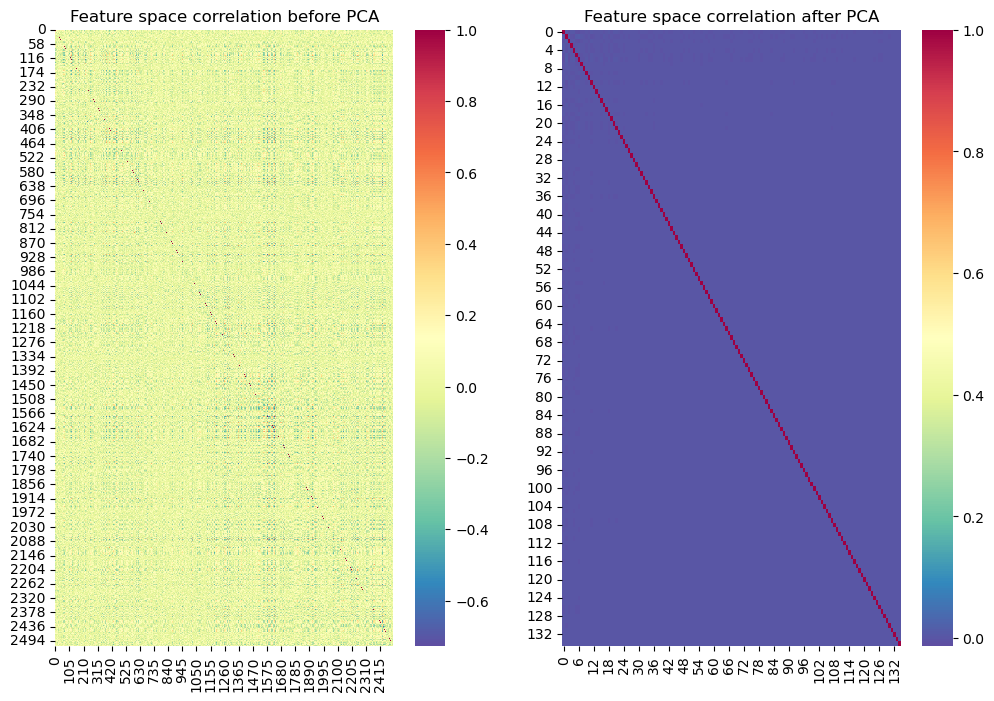

In [15]:
# Lastly, check if new data with reduced dimensions shows any high correlation & compare with data before dimensionality reduction.
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.heatmap(log_ret_norm_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation before PCA')
plt.subplot(1,2,2)
sns.heatmap(log_ret_final_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation after PCA')

---

#### 2.2 Perform clustering using K-means 

##### Baseline K-means model

Train a K-means with a pre-defined number of clusters - 11, which follows the sector breakdown based on the GICS norms specified by MSCI. S&P 500 uses the same classification rules.   

In [16]:
# Standardise data for clustering 
log_ret_final_norm_df = std_normalise_data(log_ret_final_df)
log_ret_final_norm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
ticker,,,,,,,,,,,,,,,,,,,,,
A,0.082482,-0.087096,-0.003839,-0.035686,-0.063841,-0.036236,-0.150873,0.109590,-0.068491,-0.054166,...,0.002374,0.132236,-0.039431,-0.049339,-0.164764,0.029950,0.005954,-0.070701,0.014164,0.118363
AAL,0.073242,-0.009886,-0.050344,-0.138181,0.103794,-0.019111,0.211935,0.193747,-0.150624,-0.045889,...,0.068399,0.021430,-0.035354,-0.065681,0.040438,-0.017213,0.014021,0.107586,0.075013,0.052031
AAP,-0.014070,-0.017734,-0.048509,0.005073,0.140397,0.111904,0.185589,0.033643,0.071875,0.138094,...,-0.026264,0.031616,-0.085593,-0.057257,0.107546,0.027909,0.025115,-0.037787,-0.046323,-0.036092
AAPL,0.015741,-0.095905,-0.011504,0.018782,-0.049901,-0.023559,0.065907,-0.116057,-0.027983,0.073567,...,-0.040009,-0.024982,-0.277053,-0.019955,0.134895,0.028114,0.016412,0.017477,-0.020871,0.085264
ABC,-0.041308,-0.066394,-0.106312,0.028388,-0.025859,0.209398,-0.018080,0.118439,-0.151140,0.080088,...,-0.073294,0.063508,-0.033251,-0.024642,0.102004,0.011616,0.082833,0.030510,0.035920,0.036962


In [17]:
def kmeans_baseline(data = pd.DataFrame(), init_method: str='k-means++'):
    """
    Runs a baseline K-means clustering model with k=11.
    """
    kmeans_11 = KMeans(n_clusters = 11, init=init_method, max_iter = 20000, n_init=10, random_state=1500)
    kmeans_11.fit(data)

    # predict the clusters for all stocks
    kmeans_11_clusters = pd.DataFrame(index=data.index, columns=['cluster'])
    kmeans_11_clusters['cluster'] = list(kmeans_11.predict(data))
    kmeans_11_clusters['sector'] = [sp500_profile_df[sp500_profile_df.ticker == tkr]['sector'].values[0] for tkr in kmeans_11_clusters.index]
    kmeans_11_clusters['cluster'].value_counts()

    return kmeans_11_clusters, kmeans_11

km_baseline_1_df, km_baseline_1 = kmeans_baseline(log_ret_final_norm_df)
km_baseline_2_df, km_baseline_2 = kmeans_baseline(log_ret_final_norm_df, init_method='random')

 'k-means++' selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is "greedy k-means++". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.

'random' choose n_clusters observations (rows) at random from data for the initial centroids.

Observations:

 1. The baseline K-means model (with k=11) results are pretty much similar in both the cases as can be seen above. So the choice of sampling technique is not having a major impact on stock clustering.

The next training approach is the test with Kmeans initial clusters set to 'random'. It again considers a pre-defined cluster size of 11.

KMeans clusters stacked against sectors (kmeans++ initialisation)


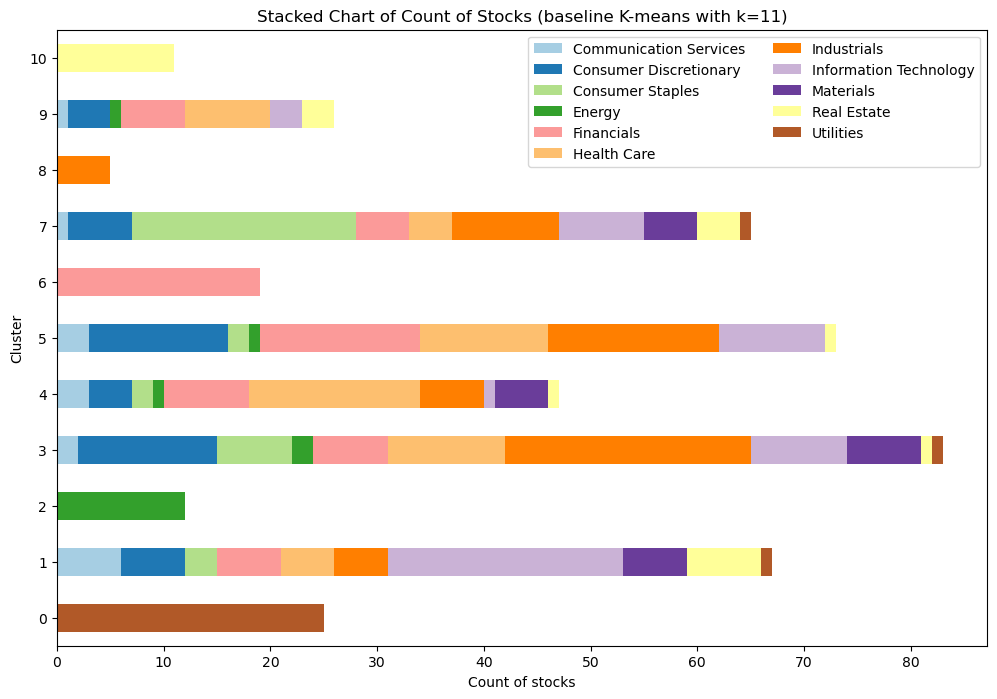

KMeans clusters stacked against sectors (random initialisation)


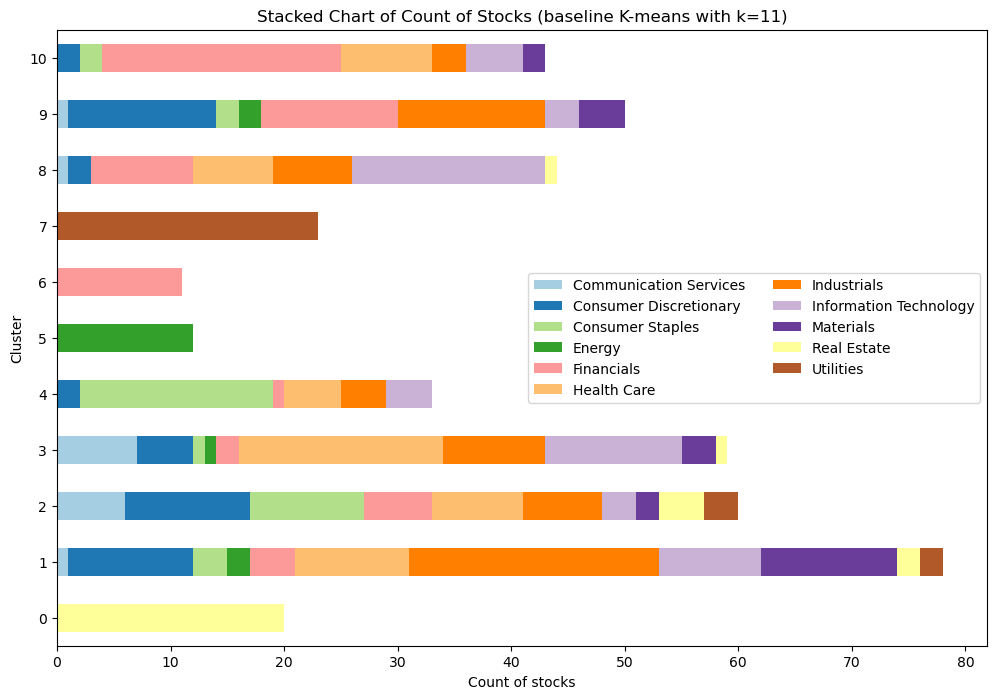

In [18]:
def plot_sector_cluster_stacked_chart(cluster_df=pd.DataFrame()):
    """
    Plot stacked chart of count of stocks across sectors & clusters.
    """
    cross_tab = pd.crosstab(index=cluster_df.cluster, columns=cluster_df.sector)
    cross_tab.plot(kind='barh', stacked=True, colormap=cm.Paired, figsize=(12, 8))
    plt.legend(loc="best", ncol=2)
    plt.ylabel("Cluster")
    plt.xlabel("Count of stocks")
    plt.title("Stacked Chart of Count of Stocks (baseline K-means with k=11)")
    plt.show()


print('KMeans clusters stacked against sectors (kmeans++ initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_1_df)

print('KMeans clusters stacked against sectors (random initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_2_df)

##### Method 1: Elbow method of choosing 'k'

Within-cluster variance is a measure of compactness of the cluster. Lower the value of within cluster variance, higher the compactness of cluster formed.

Sum of within-cluster variance, W, is calculated for clustering analyses done with different values of k. W is a cumulative measure how good the points are clustered in the analysis. Plotting the k values and their corresponding sum of within-cluster variance helps in finding the number of clusters. Initially, error measure (within-cluster variance) decreases with increase in cluster count. After a particular point, say k, Error measure starts flattening. Let's check the value of 'k' in our case

In [19]:
def plot_elbow_curve(data = pd.DataFrame(), k_min: int=2, k_max: int=50, init: str='k-means++'):
    """
    Plot the elbow curve to find optimal 'k' for k-means.
    """
    WSS = []
    k_range = range(k_min, k_max) 
    for k in k_range:
        km = KMeans(n_clusters = k, init=init, max_iter=20000, n_init=10, random_state=1500)
        km.fit(data)
        WSS += [km.inertia_]
   
    plt.plot(k_range, WSS, color='violet', marker='*')
    plt.xlabel('k')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.title(f'Elbow Curve: Plot of K vs WCSS (init={init})')
    knee = KneeLocator(k_range, WSS, curve='convex', direction='decreasing', interp_method='interp1d')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    print(f'Knee point, WCSS : {knee.knee, WSS[knee.knee]}')
    plt.figtext(0.5, 0.5, f'k = {knee.knee}', bbox=dict(facecolor='red', alpha=0.3), fontsize=12)
    plt.show()

    return knee.knee

Knee point, WCSS : (9, 377.0875123527392)


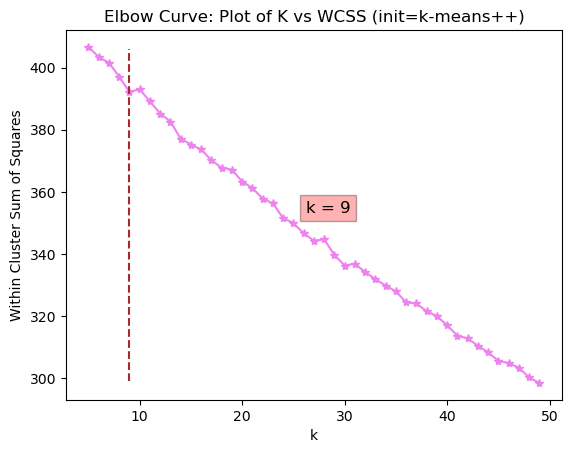

Knee point k value: 9


In [20]:
knee_point_k = plot_elbow_curve(data=log_ret_final_norm_df, k_min=5, k_max=50)
print(f'Knee point k value: {knee_point_k}')

The elbow method says that the optimal 'k' value is 9. This is almost inline with our baseline model of 11 clusters.

We'll pick k=9 and fit K-means model on our data and find out how it performs.

In [21]:
k_final = knee_point_k # we get this value from Elbow test
km_final = KMeans(n_clusters = k_final, init='k-means++', max_iter=20000, n_init=10, random_state=1500)
km_final = km_final.fit(log_ret_final_norm_df)
km_final_clusters_df = pd.DataFrame(index=log_ret_final_norm_df.index, columns=['cluster', 'sector'])
km_final_clusters_df['cluster'] = km_final.labels_
km_final_clusters_df['sector'] = [sp500_profile_df[sp500_profile_df.ticker == tkr]['sector'].values[0] for tkr in km_final_clusters_df.index]
km_final_clusters_df.cluster.value_counts()

cluster
5    139
0    112
4     54
1     35
6     25
8     24
2     17
3     16
7     11
Name: count, dtype: int64

#### Now, on to Model evaluation 

#### 1. Silhouette coefficient

Once clustering is done, how well the clustering has performed can be quantified by a number of metrics. Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distance.

There are majorly two types of measures to assess the clustering performance.

1. Extrinsic Measures - which require ground truth labels.
2. Intrinsic Measures - which do not require ground truth labels.

Silhouette Coefficient is an intrinsic measure that measures between-cluster distances against within-cluster distances. A higher ratio signifies the cluster is far away from its nearest cluster and that the cluster is more well-defined.

In [22]:
sil_score_b = silhouette_score(log_ret_final_norm_df, labels=km_baseline_2.labels_, random_state=1500)
print(f'\nThe Silhouette Score for K-means baseline model (k=11) fit on preprocessed returns data : {sil_score_b}')
sil_score = silhouette_score(log_ret_final_norm_df, labels=km_final.labels_, random_state=1500)
print(f'\nThe Silhouette Score for our K-means model (k={k_final}) fit on preprocessed returns data : {sil_score}')


The Silhouette Score for K-means baseline model (k=11) fit on preprocessed returns data : 0.04399172234567745

The Silhouette Score for our K-means model (k=9) fit on preprocessed returns data : 0.04255332933076346


The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. Our score of 0.2, although close to zero (means overlapping clusters), is still positive. 

#### 2. Calinski-Harabasz Index

If the ground truth labels are not known, the Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

In [23]:
cal_hb_score_b = calinski_harabasz_score(log_ret_final_norm_df, labels=km_baseline_2.labels_)
print(f'\nThe Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed returns data : {cal_hb_score_b}')
cal_hb_score = calinski_harabasz_score(log_ret_final_norm_df, labels=km_final.labels_)
print(f'\nThe Calinski Harabasz Score for our K-means model (k={k_final}) fit on preprocessed returns data : {cal_hb_score}') 


The Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed returns data : 4.832294655691114

The Calinski Harabasz Score for our K-means model (k=9) fit on preprocessed returns data : 5.475938758894829


In [24]:
def plot_TSNE(data, labels):
    """
    Plot the results of the TSNE algorithm to visualise the 
    cluster densities
    """
    # all stock with its cluster label (including -1)
    clustered_series_all = pd.Series(index=data.index, data=labels)
    # with only actual clusters 
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # to plot multidimension into 2D
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(data)

    plt.figure(1, facecolor='white', figsize=(8,6))
    plt.clf()
    plt.axis('off')

    # clustered
    clst_plot = plt.scatter(
    X_tsne[(clustered_series_all!=-1).values, 0],
    X_tsne[(clustered_series_all!=-1).values, 1],
    s=100, alpha=0.9, c=labels[labels!=-1], cmap=cm.Paired_r, marker='*')
    # unclustered in the background
    plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100, alpha=0.05)

    handles, _ = clst_plot.legend_elements(prop='colors')
    plt.legend(handles, clustered_series.value_counts().index)
    plt.title('T-SNE of all Stocks with Clusters Noted')
    plt.show()

    return clustered_series_all


# show number of stocks in each cluster 
def plot_cluster_counts(labels_df):
    """
    Plot cluster counts histogram bar chart
    """
    plt.figure(figsize=(8,6))
    plt.barh(
    range(len(labels_df[labels_df!=-1].value_counts())), labels_df[labels_df!=-1].value_counts())
    plt.title('Cluster Member Counts')
    plt.xlabel('Stocks in Cluster')
    plt.ylabel('Cluster Number')
    plt.show()

# plot price movements for cluster members
def plot_cluster_members(labels_df):
    """
    Plot the cluster members' log prices
    to observe if they follow a similar path 
    """
    # get the number of stocks in each cluster 
    counts = labels_df[labels_df!=-1].value_counts()

    # let's visualize some clusters
    cluster_vis_list = list(counts[counts>1].index)[::-1]

    sf = stocks_hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')

    # plot a handful of the smallest clusters
    for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]: 
        tickers = list(labels_df[labels_df==clust].index) 
        means = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers].mean())
        data = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers]).sub(means) 
        data.plot(title='Stock Time Series for Cluster %d' % clust)
        plt.show()


------------------------------------

TSNE plot for the model



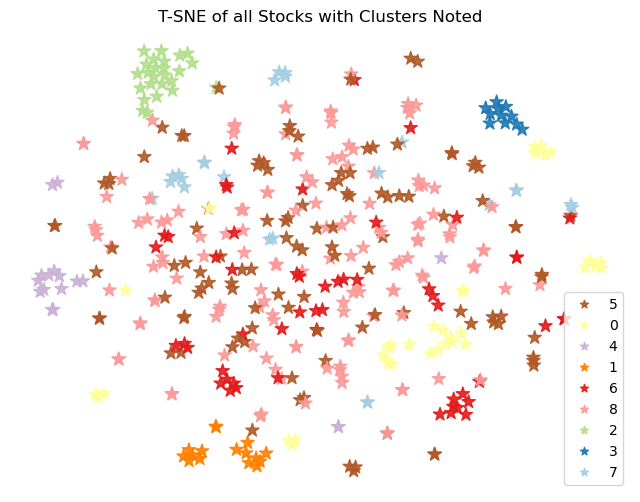


------------------------------------

Cluster counts bar chart



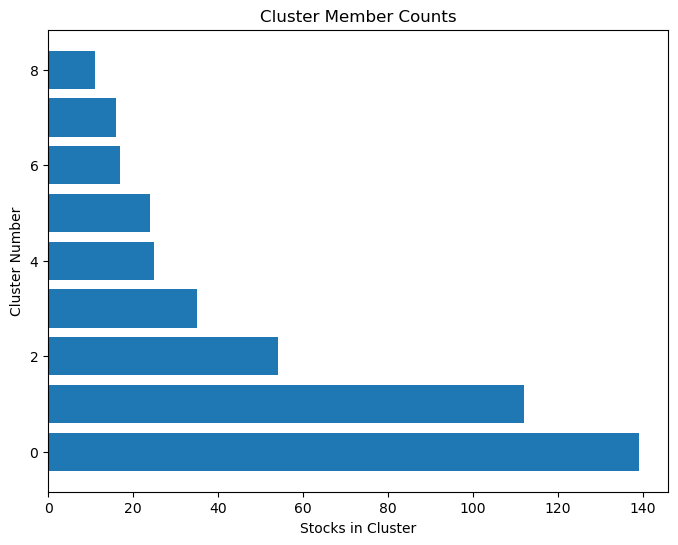


------------------------------------

Cluster member price movements: sample plots of 4 least dense clusters



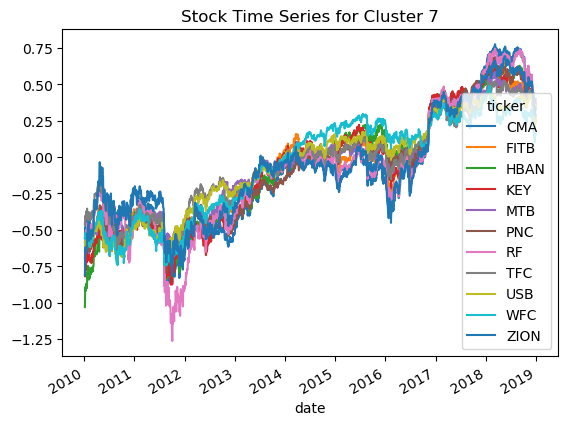

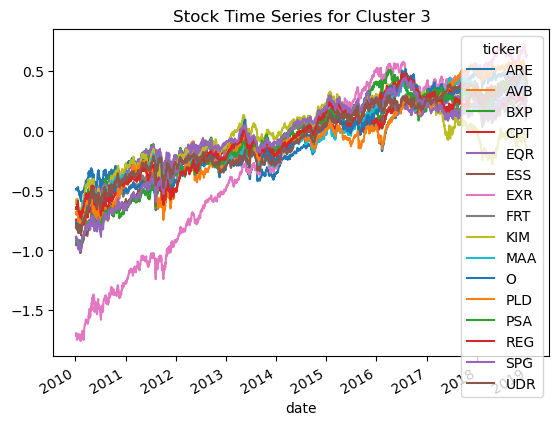

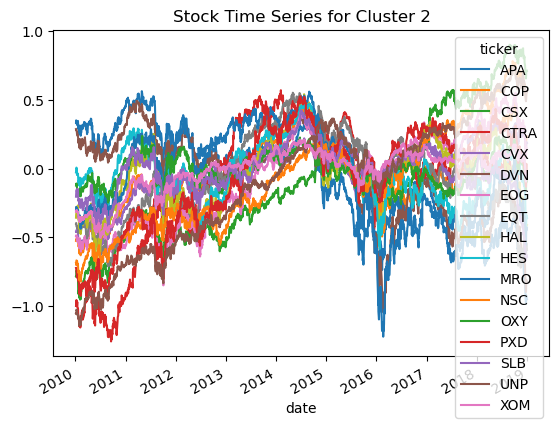

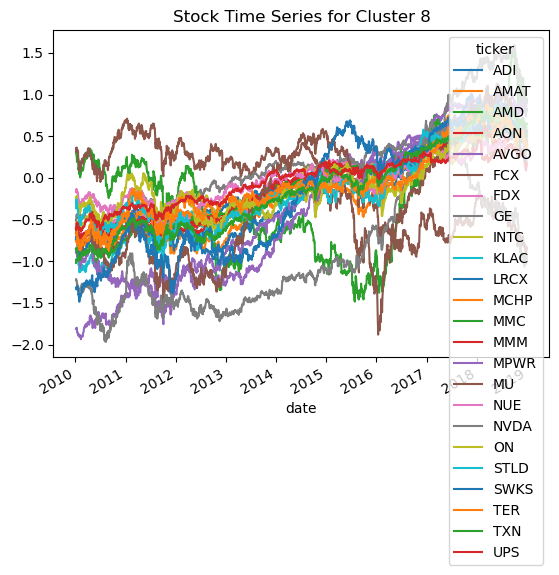

In [25]:
def km_final_plots(data, k: int, labels):
    """
    Plot all charts for the K-means model predictions 
    """
    # TSNE
    print('\n------------------------------------\n')
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('\n------------------------------------\n')
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('\n------------------------------------\n')
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

km_final_plots(log_ret_final_norm_df, k_final, labels=km_final.labels_)

---

#### 3.3 OPTICS Clustering

OPTICS stands for Ordering points to identify the clustering structure. It is a density-based unsupervised learning algorithm, which was developed by the same research group that developed DBSCAN.

A single cutoff of distance is applied in DBSCAN to determine whether two data points are close to each other (neighbors) or not. But it may not always be an ideal solution because a “long” distance in one cluster could be a “short” distance in another. In OPTICS each point is assigned a core distance that describes the distance to the MinPtsth closest point, and a reachability distance of another point o from a point p that is either the distance between o and p, or the core distance of p, whichever is bigger.

Running the OPTICS model
----------------------------------------------------------------------------------------------------
max_eps: inf
min_samples: 4
model fit params: {'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 4, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.05}

db.cluster_hierarchy_: 
[[  0   4]
 [ 44  48]
 [ 54  61]
 [ 68  73]
 [ 77  80]
 [ 92  97]
 [ 99 108]
 [ 90 108]
 [122 125]
 [127 136]
 [138 142]
 [127 142]
 [162 166]
 [167 172]
 [175 180]
 [213 231]
 [210 233]
 [240 251]
 [258 261]
 [326 329]
 [344 347]
 [367 371]
 [381 386]
 [388 391]
 [  0 432]]


The Silhouette Score for our OPTICS model fit on preprocessed returns data : 0.07257237375111653

The Calinski Harabasz Score for our OPTICS model fit on preprocessed returns data : 4.605105424409096
-----------------------------------------------------------

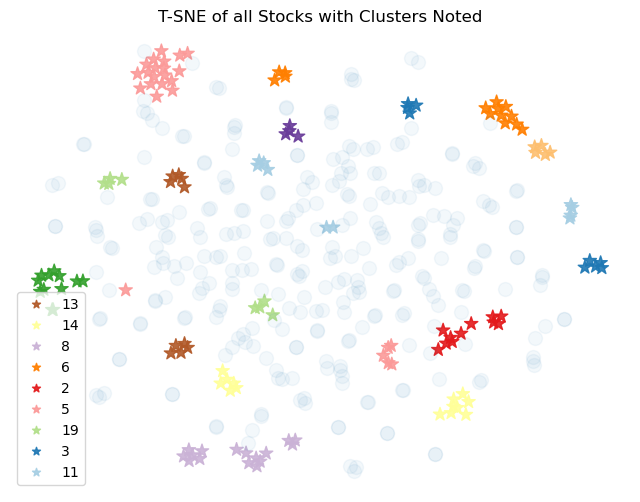

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart



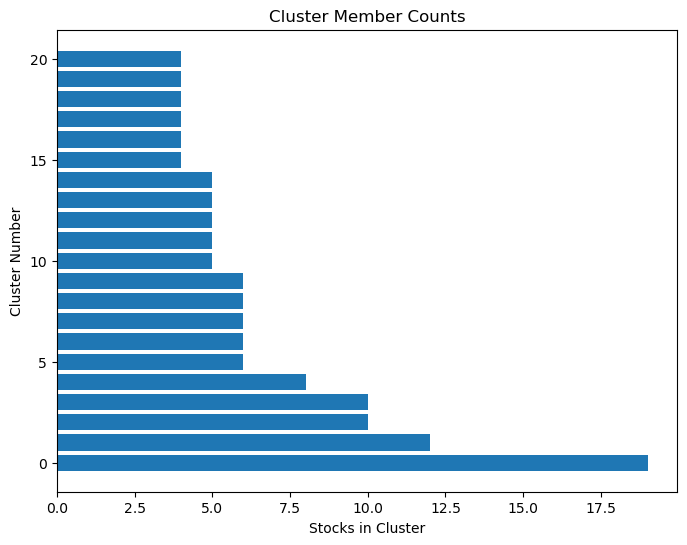

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters



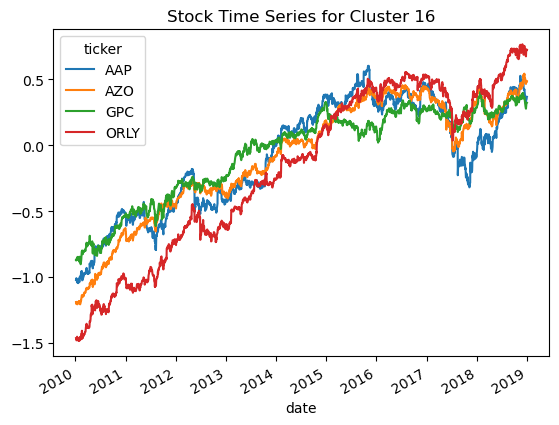

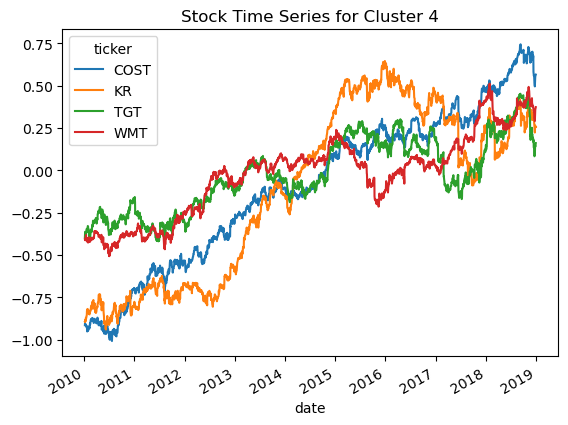

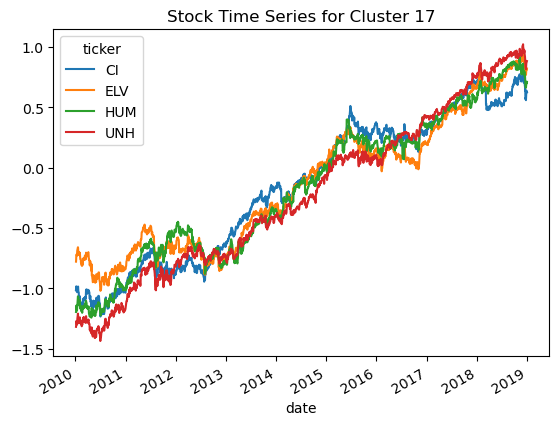

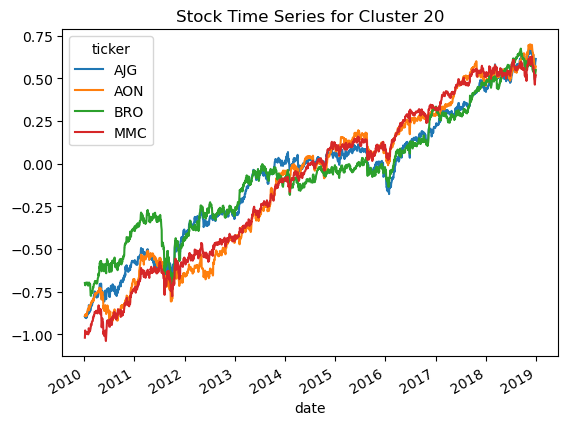

In [26]:
def optics_plots(data, max_eps: float=np.inf, min_samples: int=5):
    """
    Fit OPTICS clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running the OPTICS model')
    print('--'*50)
    print(f'max_eps: {max_eps}\nmin_samples: {min_samples}')
    db = OPTICS(max_eps=max_eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    print(f'model fit params: {db.get_params()}\n')
    print(f'db.cluster_hierarchy_: \n{db.cluster_hierarchy_}\n')

    sil_score = silhouette_score(data, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our OPTICS model fit on preprocessed returns data : {sil_score}')

    cal_hb_score = calinski_harabasz_score(data, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our OPTICS model fit on preprocessed returns data : {cal_hb_score}') 

    # TSNE
    print('--'*100)
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

optics_plots(log_ret_final_norm_df, min_samples=4)

---